<a href="https://colab.research.google.com/github/Vishnu0920/Reinforcement_Learning/blob/main/RL_Assignemnt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training On-Policy Monte Carlo Agent...
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Episode 1000 completed.
Episode 1100 completed.
Episode 1200 completed.
Episode 1300 completed.
Episode 1400 completed.
Episode 1500 completed.
Episode 1600 completed.
Episode 1700 completed.
Episode 1800 completed.
Episode 1900 completed.
Episode 2000 completed.
Episode 2100 completed.
Episode 2200 completed.
Episode 2300 completed.
Episode 2400 completed.
Episode 2500 completed.
Episode 2600 completed.
Episode 2700 completed.
Episode 2800 completed.
Episode 2900 completed.
Episode 3000 completed.
Episode 3100 completed.
Episode 3200 completed.
Episode 3300 completed.
Episode 3400 completed.
Episode 3500 completed.
Episode 3600 completed.
Episode 3700 completed.
Episode 3800 completed.
Episode 3900 completed.
Episode 4000 completed.
Episode 4

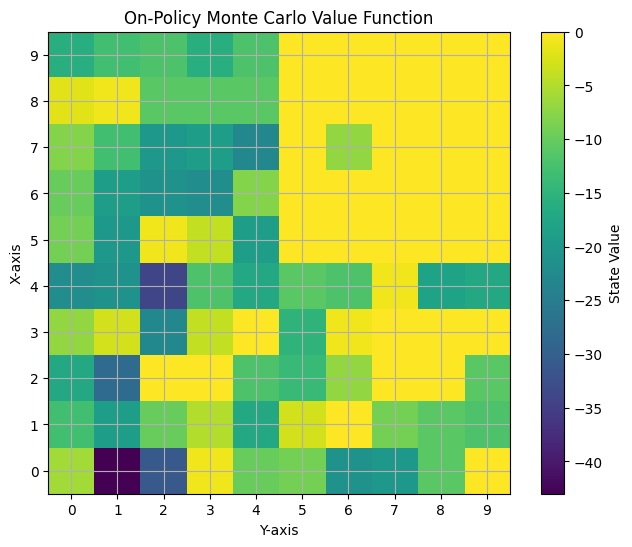

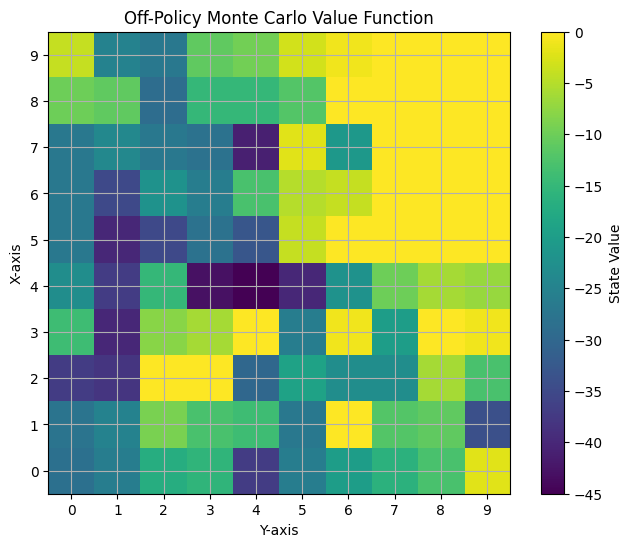

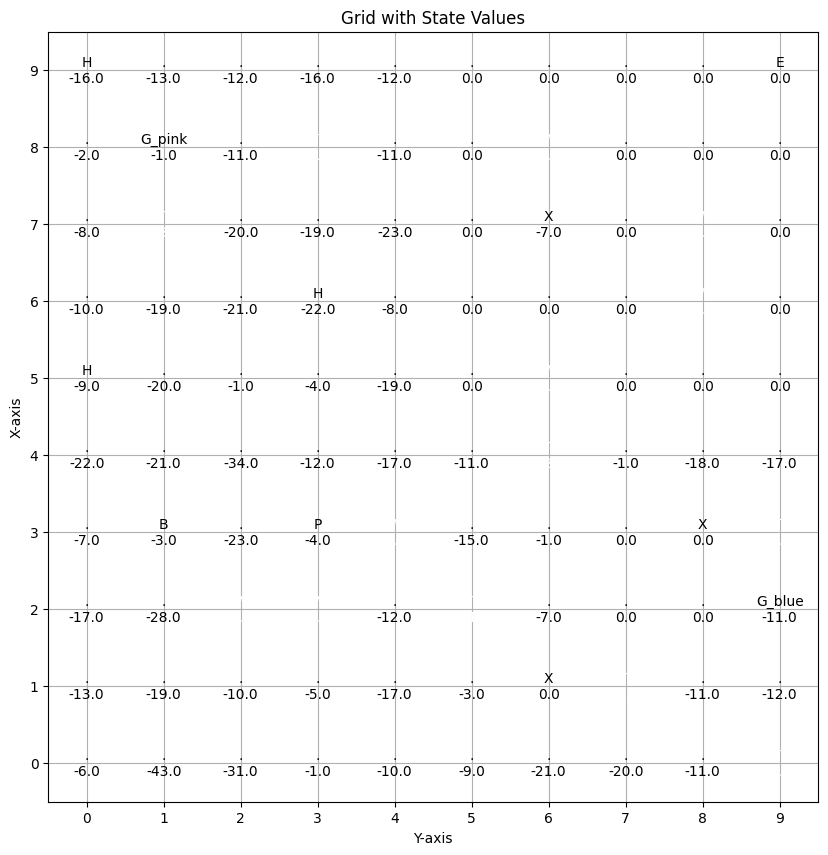

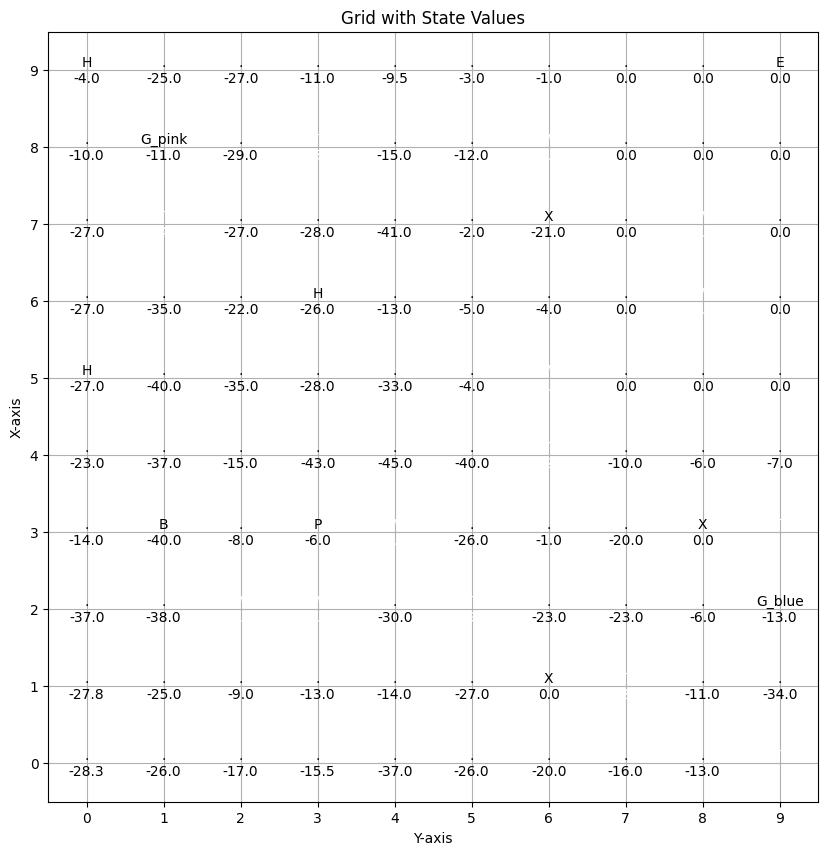

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define constants
GRID_SIZE = 10
START_POS = (0, 0)
EXIT_POS = (9, 9)
START_HEALTH = 50
MOVEMENT_COST = -1
TRAP_PENALTY = -10
HEALTH_BOOST = +5
EXIT_REWARD = +1000
GAMMA = 1
EPSILON = 0.1  # For epsilon-greedy policy

# Define grid elements
class GridElement:
    EMPTY = '.'
    BLUE_KEY = 'B'
    PINK_KEY = 'P'
    GREEN_KEY_PINK = 'G_pink'
    GREEN_KEY_BLUE = 'G_blue'
    TRAP = 'T'
    HEALTH_BOOST = 'H'
    WALL = 'W'
    TELEPORT = 'X'
    EXIT = 'E'

# Initialize the grid
def initialize_grid():
    grid = np.full((GRID_SIZE, GRID_SIZE), GridElement.EMPTY, dtype=object)

    # Orange Section
    grid[3,1] = GridElement.BLUE_KEY
    grid[3,3] = GridElement.PINK_KEY
    grid[2,2] = GridElement.WALL
    grid[2,3] = GridElement.WALL
    grid[3,4] = GridElement.WALL

    # Pink Section
    grid[5,0] = GridElement.HEALTH_BOOST
    grid[9,0] = GridElement.HEALTH_BOOST
    grid[6,3] = GridElement.HEALTH_BOOST
    grid[7,1] = GridElement.TRAP
    grid[8,3] = GridElement.TRAP
    grid[8,1] = GridElement.GREEN_KEY_PINK

    # Blue Section
    grid[2,5] = GridElement.TRAP
    grid[1,7] = GridElement.TRAP
    grid[4,6] = GridElement.TRAP
    grid[3,9] = GridElement.TRAP
    grid[0,9] = GridElement.TRAP
    grid[2,9] = GridElement.GREEN_KEY_BLUE
    grid[1,6] = GridElement.TELEPORT
    grid[3,8] = GridElement.TELEPORT

    # Green Section
    grid[5,6] = GridElement.WALL
    grid[8,6] = GridElement.WALL
    grid[6,8] = GridElement.WALL
    grid[7,8] = GridElement.WALL
    grid[7,6] = GridElement.TELEPORT
    grid[9,9] = GridElement.EXIT

    return grid

# Define actions
ACTIONS = ['Up', 'Down', 'Left', 'Right']

# Define movement directions
action_effect = {
    'Up': (-1, 0),
    'Down': (1, 0),
    'Left': (0, -1),
    'Right': (0, 1)
}

# Define the teleportation mapping
# Teleport from Blue Section teleporters to Green Section teleport destination
TELEPORT_MAPPING = {
    (1,6): (7,6),
    (3,8): (7,6)
}

# Define the behavior for the Green Section stochasticity
def move_in_green_section(action):
    if np.random.rand() < 0.8:
        return action
    else:
        # Move in the opposite direction
        opposite = {
            'Up': 'Down',
            'Down': 'Up',
            'Left': 'Right',
            'Right': 'Left'
        }
        return opposite[action]

# Define the Environment
class GridEnvironment:
    def __init__(self, grid):
        self.grid = grid
        self.reset()

    def reset(self):
        self.agent_pos = START_POS
        self.health = START_HEALTH
        self.keys = {'B': False, 'P': False, 'G': False}
        self.done = False
        return self._get_state()

    def _get_state(self):
        return (self.agent_pos[0], self.agent_pos[1],
                self.keys['B'], self.keys['P'], self.keys['G'], self.health)

    def step(self, action):
        if self.done:
            raise Exception("Episode has ended. Reset the environment.")

        x, y = self.agent_pos
        # Check if in Green Section for stochasticity
        in_green = (5 <= x <= 9) and (5 <= y <= 9)
        if in_green:
            action = move_in_green_section(action)

        dx, dy = action_effect[action]
        new_x, new_y = x + dx, y + dy

        # Check grid boundaries
        if not (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE):
            new_x, new_y = x, y  # Hit boundary wall

        # Check if moving into a section requires a key
        target_section = self.get_section(new_x, new_y)
        if target_section == 'Blue' and not self.keys['B']:
            # Locked section
            new_x, new_y = x, y
        elif target_section == 'Pink' and not self.keys['P']:
            new_x, new_y = x, y
        elif target_section == 'Green' and not self.keys['G']:
            new_x, new_y = x, y

        # Check for walls
        if self.grid[new_x, new_y] == GridElement.WALL:
            new_x, new_y = x, y  # Hit a wall

        # Apply movement cost
        self.health += MOVEMENT_COST

        # Check if movement was into a wall or locked section
        if (new_x, new_y) == (x, y):
            reward = MOVEMENT_COST
        else:
            reward = MOVEMENT_COST
            self.agent_pos = (new_x, new_y)

            # Check for grid elements
            cell = self.grid[new_x, new_y]

            # Handle teleportation
            if cell == GridElement.TELEPORT:
                # Teleportation cost already applied
                self.agent_pos = TELEPORT_MAPPING.get((new_x, new_y), self.agent_pos)

            # Handle keys
            if cell == GridElement.BLUE_KEY:
                self.keys['B'] = True
            elif cell == GridElement.PINK_KEY:
                self.keys['P'] = True
            elif cell in [GridElement.GREEN_KEY_PINK, GridElement.GREEN_KEY_BLUE]:
                self.keys['G'] = True

            # Handle traps
            if cell == GridElement.TRAP:
                self.health += TRAP_PENALTY
                reward += TRAP_PENALTY

            # Handle health boosts
            if cell == GridElement.HEALTH_BOOST:
                self.health += HEALTH_BOOST
                reward += HEALTH_BOOST

            # Handle exit
            if cell == GridElement.EXIT:
                reward += EXIT_REWARD
                self.done = True

        # Check if health is depleted
        if self.health <= 0:
            self.done = True

        return self._get_state(), reward, self.done

    def get_section(self, x, y):
        if 0 <= x <=4 and 0 <= y <=4:
            return 'Orange'
        elif 0 <= x <=4 and 5 <= y <=9:
            return 'Blue'
        elif 5 <= x <=9 and 0 <= y <=4:
            return 'Pink'
        elif 5 <= x <=9 and 5 <= y <=9:
            return 'Green'
        return 'Unknown'

# Define the Monte Carlo Agent
class MonteCarloAgent:
    def __init__(self, env, gamma=1.0, epsilon=0.1, method='On-Policy'):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method
        self.value_table = defaultdict(float)
        self.returns = defaultdict(list)
        self.policy = defaultdict(lambda: random.choice(ACTIONS))

    def generate_episode(self):
        episode = []
        state = self.env.reset()
        while True:
            state_key = self._state_to_key(state)
            action = self._choose_action(state_key)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode

    def _state_to_key(self, state):
        return state  # Using the entire state as the key

    def _choose_action(self, state_key):
        if self.method == 'On-Policy':
            # Epsilon-greedy policy
            if np.random.rand() < self.epsilon:
                return random.choice(ACTIONS)
            else:
                return self.policy[state_key]
        elif self.method == 'Off-Policy':
            # Behavior policy (random for simplicity)
            return random.choice(ACTIONS)

    def update_value_table(self, episode):
        G = 0
        visited_states = set()
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            state_key = self._state_to_key(state)
            # Every-Visit MC: Update for every occurrence
            self.returns[state_key].append(G)
            self.value_table[state_key] = np.mean(self.returns[state_key])
            if self.method == 'On-Policy':
                # Update policy to be greedy w.r.t. value function
                self.policy[state_key] = self._best_action(state, G)

    def _best_action(self, state, G):
        # Simple greedy policy: choose the action that leads to the highest value
        # For simplicity, here we just keep the existing policy
        # A more sophisticated approach would involve estimating action-values
        return self.policy[self._state_to_key(state)]

    def train(self, num_episodes=1000):
        for episode_num in range(1, num_episodes+1):
            episode = self.generate_episode()
            self.update_value_table(episode)
            if episode_num % 100 == 0:
                print(f"Episode {episode_num} completed.")

    def get_value_grid(self):
        grid_values = np.zeros((GRID_SIZE, GRID_SIZE))
        for state_key, value in self.value_table.items():
            x, y = state_key[0], state_key[1]
            grid_values[x, y] = value
        return grid_values

# Initialize grid and environment
grid = initialize_grid()
env = GridEnvironment(grid)

# Initialize agents
on_policy_agent = MonteCarloAgent(env, gamma=GAMMA, epsilon=EPSILON, method='On-Policy')
off_policy_agent = MonteCarloAgent(env, gamma=GAMMA, epsilon=EPSILON, method='Off-Policy')

# Train On-Policy Agent
print("Training On-Policy Monte Carlo Agent...")
on_policy_agent.train(num_episodes=5000)

# Train Off-Policy Agent
print("Training Off-Policy Monte Carlo Agent...")
off_policy_agent.train(num_episodes=5000)

# Get value grids
on_policy_values = on_policy_agent.get_value_grid()
off_policy_values = off_policy_agent.get_value_grid()

# Visualization
def plot_value_grid(grid_values, title):
    plt.figure(figsize=(8,6))
    plt.imshow(grid_values, cmap='viridis', origin='lower')
    plt.colorbar(label='State Value')
    plt.title(title)
    plt.xlabel('Y-axis')
    plt.ylabel('X-axis')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.grid(True)
    plt.show()

# Plot On-Policy Value Grid
plot_value_grid(on_policy_values, 'On-Policy Monte Carlo Value Function')

# Plot Off-Policy Value Grid
plot_value_grid(off_policy_values, 'Off-Policy Monte Carlo Value Function')

# Display the grid with value annotations
def display_grid_with_values(grid, grid_values):
    plt.figure(figsize=(10,10))
    plt.imshow(np.zeros((GRID_SIZE, GRID_SIZE)), cmap='Greys', origin='lower')
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            cell = grid[x, y]
            value = grid_values[x, y]
            plt.text(y, x, f"{cell}\n{value:.1f}", ha='center', va='center', color='white' if cell in [GridElement.WALL, GridElement.TRAP] else 'black')
    plt.title('Grid with State Values')
    plt.xlabel('Y-axis')
    plt.ylabel('X-axis')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.grid(True)
    plt.show()

# Display On-Policy Grid Values
display_grid_with_values(grid, on_policy_values)

# Display Off-Policy Grid Values
display_grid_with_values(grid, off_policy_values)



In [ ]:
# Episode sequence of states (excluding teleportation)
states = [(0,0), (1,0), (1,1), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5),
          (2,5), (1,5), (1,6), (1,7), (7,6), (7,7), (7,8), (8,8), (9,8), (9,9)]

# Rewards for each step: -1 per move, +1000 at the exit (9,9)
rewards = [-1] * (len(states) - 1) + [1000]

# Initialize state values
state_values = {}
G = 0  # Return (reward) at the final state

# Loop backwards through the episode to calculate returns
for t in range(len(states) - 1, -1, -1):
    G = rewards[t] + G  # Accumulate the return
    state_values[states[t]] = G  # Assign return to the state

# Output the state values
state_values


{(9, 9): 1000,
 (9, 8): 999,
 (8, 8): 998,
 (7, 8): 997,
 (7, 7): 996,
 (7, 6): 995,
 (1, 7): 994,
 (1, 6): 993,
 (1, 5): 992,
 (2, 5): 991,
 (3, 5): 990,
 (3, 4): 989,
 (3, 3): 988,
 (3, 2): 987,
 (3, 1): 986,
 (2, 1): 985,
 (1, 1): 984,
 (1, 0): 983,
 (0, 0): 982}

Training On-Policy Monte Carlo Agent...
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Episode 1000 completed.
Episode 1100 completed.
Episode 1200 completed.
Episode 1300 completed.
Episode 1400 completed.
Episode 1500 completed.
Episode 1600 completed.
Episode 1700 completed.
Episode 1800 completed.
Episode 1900 completed.
Episode 2000 completed.
Episode 2100 completed.
Episode 2200 completed.
Episode 2300 completed.
Episode 2400 completed.
Episode 2500 completed.
Episode 2600 completed.
Episode 2700 completed.
Episode 2800 completed.
Episode 2900 completed.
Episode 3000 completed.
Episode 3100 completed.
Episode 3200 completed.
Episode 3300 completed.
Episode 3400 completed.
Episode 3500 completed.
Episode 3600 completed.
Episode 3700 completed.
Episode 3800 completed.
Episode 3900 completed.
Episode 4000 completed.
Episode 4

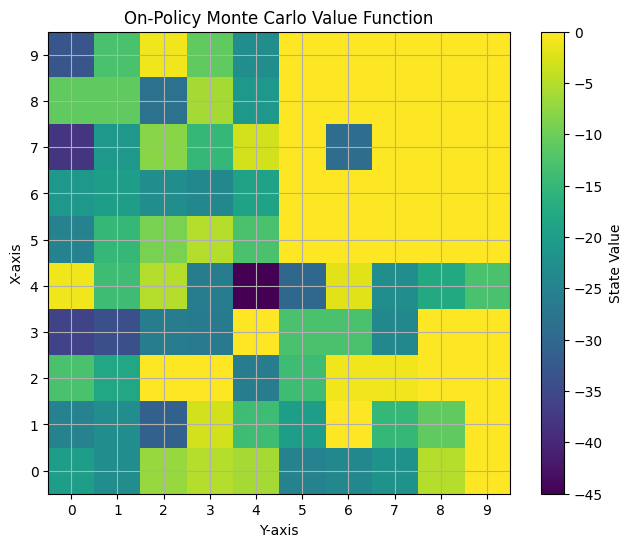

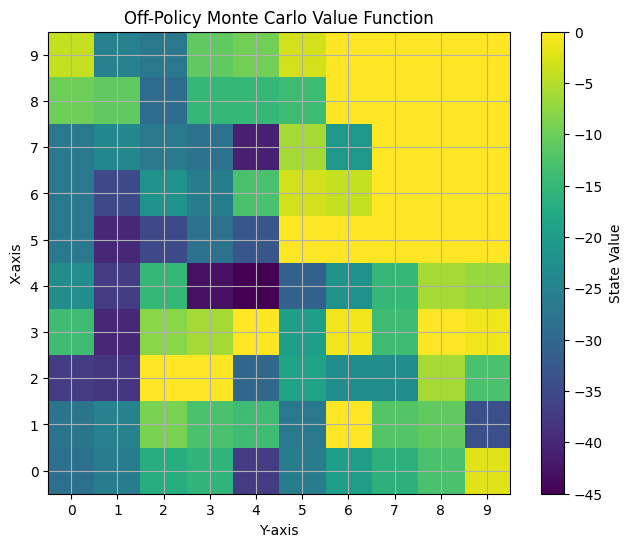

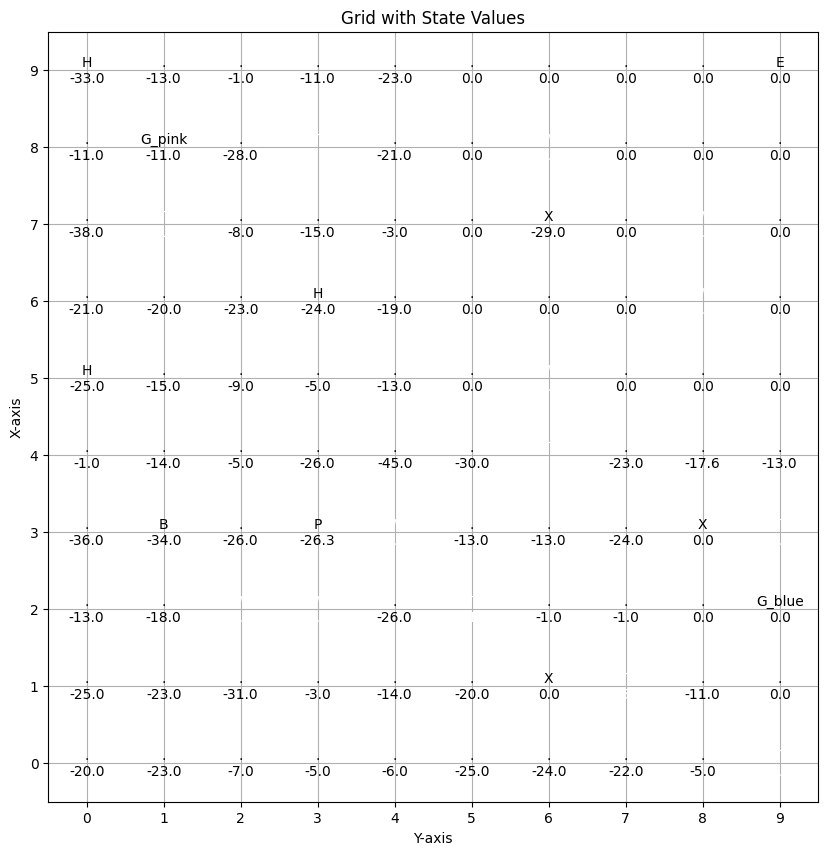

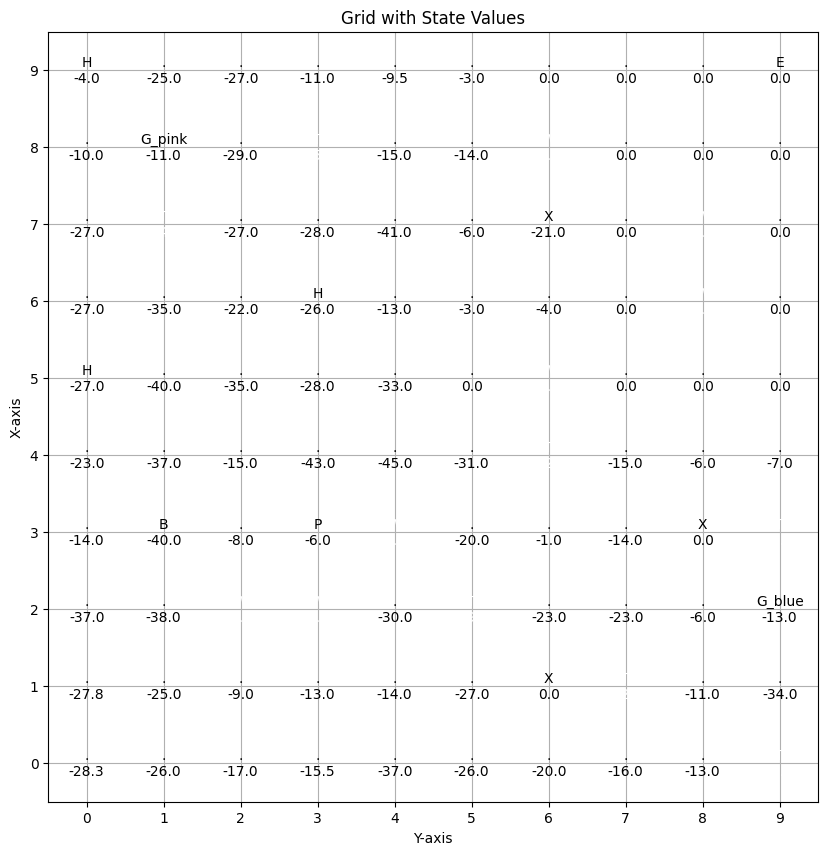

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define constants
GRID_SIZE = 10
START_POS = (0, 0)
EXIT_POS = (9, 9)
START_HEALTH = 50
MOVEMENT_COST = -1
TRAP_PENALTY = -10
HEALTH_BOOST = +5
EXIT_REWARD = +1000
GAMMA = 1
EPSILON = 0.1  # For epsilon-greedy policy

# Define grid elements
class GridElement:
    EMPTY = '.'
    BLUE_KEY = 'B'
    PINK_KEY = 'P'
    GREEN_KEY_PINK = 'G_pink'
    GREEN_KEY_BLUE = 'G_blue'
    TRAP = 'T'
    HEALTH_BOOST = 'H'
    WALL = 'W'
    TELEPORT = 'X'
    EXIT = 'E'

# Initialize the grid
def initialize_grid():
    grid = np.full((GRID_SIZE, GRID_SIZE), GridElement.EMPTY, dtype=object)

    # Orange Section
    grid[3,1] = GridElement.BLUE_KEY
    grid[3,3] = GridElement.PINK_KEY
    grid[2,2] = GridElement.WALL
    grid[2,3] = GridElement.WALL
    grid[3,4] = GridElement.WALL

    # Pink Section
    grid[5,0] = GridElement.HEALTH_BOOST
    grid[9,0] = GridElement.HEALTH_BOOST
    grid[6,3] = GridElement.HEALTH_BOOST
    grid[7,1] = GridElement.TRAP
    grid[8,3] = GridElement.TRAP
    grid[8,1] = GridElement.GREEN_KEY_PINK

    # Blue Section
    grid[2,5] = GridElement.TRAP
    grid[1,7] = GridElement.TRAP
    grid[4,6] = GridElement.TRAP
    grid[3,9] = GridElement.TRAP
    grid[0,9] = GridElement.TRAP
    grid[2,9] = GridElement.GREEN_KEY_BLUE
    grid[1,6] = GridElement.TELEPORT
    grid[3,8] = GridElement.TELEPORT

    # Green Section
    grid[5,6] = GridElement.WALL
    grid[8,6] = GridElement.WALL
    grid[6,8] = GridElement.WALL
    grid[7,8] = GridElement.WALL
    grid[7,6] = GridElement.TELEPORT
    grid[9,9] = GridElement.EXIT

    return grid

# Define actions
ACTIONS = ['Up', 'Down', 'Left', 'Right']

# Define movement directions
action_effect = {
    'Up': (-1, 0),
    'Down': (1, 0),
    'Left': (0, -1),
    'Right': (0, 1)
}

# Define the teleportation mapping
# Teleport from Blue Section teleporters to Green Section teleport destination
TELEPORT_MAPPING = {
    (1,6): (7,6),
    (3,8): (7,6)
}

# Define the behavior for the Green Section stochasticity
def move_in_green_section(action):
    if np.random.rand() < 0.8:
        return action
    else:
        # Move in the opposite direction
        opposite = {
            'Up': 'Down',
            'Down': 'Up',
            'Left': 'Right',
            'Right': 'Left'
        }
        return opposite[action]

# Define the Environment
class GridEnvironment:
    def __init__(self, grid):
        self.grid = grid
        self.reset()

    def reset(self):
        self.agent_pos = START_POS
        self.health = START_HEALTH
        self.keys = {'B': False, 'P': False, 'G': False}
        self.done = False
        return self._get_state()

    def _get_state(self):
        return (self.agent_pos[0], self.agent_pos[1],
                self.keys['B'], self.keys['P'], self.keys['G'], self.health)

    def step(self, action):
        if self.done:
            raise Exception("Episode has ended. Reset the environment.")

        x, y = self.agent_pos

        # Apply movement directly without stochasticity in the green section
        dx, dy = action_effect[action]
        new_x, new_y = x + dx, y + dy

        # Check grid boundaries
        if not (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE):
            new_x, new_y = x, y  # Hit boundary wall

        # Check if moving into a section requires a key
        target_section = self.get_section(new_x, new_y)
        if target_section == 'Blue' and not self.keys['B']:
            # Locked section
            new_x, new_y = x, y
        elif target_section == 'Pink' and not self.keys['P']:
            new_x, new_y = x, y
        elif target_section == 'Green' and not self.keys['G']:
            new_x, new_y = x, y

        # Check for walls
        if self.grid[new_x, new_y] == GridElement.WALL:
            new_x, new_y = x, y  # Hit a wall

        # Apply movement cost
        self.health += MOVEMENT_COST

        # Check if movement was into a wall or locked section
        if (new_x, new_y) == (x, y):
            reward = MOVEMENT_COST
        else:
            reward = MOVEMENT_COST
            self.agent_pos = (new_x, new_y)

            # Check for grid elements
            cell = self.grid[new_x, new_y]

            # Handle teleportation
            if cell == GridElement.TELEPORT:
                # Teleportation cost already applied
                self.agent_pos = TELEPORT_MAPPING.get((new_x, new_y), self.agent_pos)

            # Handle keys
            if cell == GridElement.BLUE_KEY:
                self.keys['B'] = True
            elif cell == GridElement.PINK_KEY:
                self.keys['P'] = True
            elif cell in [GridElement.GREEN_KEY_PINK, GridElement.GREEN_KEY_BLUE]:
                self.keys['G'] = True

            # Handle traps
            if cell == GridElement.TRAP:
                self.health += TRAP_PENALTY
                reward += TRAP_PENALTY

            # Handle health boosts
            if cell == GridElement.HEALTH_BOOST:
                self.health += HEALTH_BOOST
                reward += HEALTH_BOOST

            # Handle exit
            if cell == GridElement.EXIT:
                reward += EXIT_REWARD
                self.done = True

        # Check if health is depleted
        if self.health <= 0:
            self.done = True

        return self._get_state(), reward, self.done

    def get_section(self, x, y):
        if 0 <= x <=4 and 0 <= y <=4:
            return 'Orange'
        elif 0 <= x <=4 and 5 <= y <=9:
            return 'Blue'
        elif 5 <= x <=9 and 0 <= y <=4:
            return 'Pink'
        elif 5 <= x <=9 and 5 <= y <=9:
            return 'Green'
        return 'Unknown'


# Define the Monte Carlo Agent
class MonteCarloAgent:
    def __init__(self, env, gamma=1.0, epsilon=0.1, method='On-Policy'):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method
        self.value_table = defaultdict(float)
        self.returns = defaultdict(list)
        self.policy = defaultdict(lambda: random.choice(ACTIONS))

    def generate_episode(self):
        episode = []
        state = self.env.reset()
        while True:
            state_key = self._state_to_key(state)
            action = self._choose_action(state_key)
            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode

    def _state_to_key(self, state):
        return state  # Using the entire state as the key

    def _choose_action(self, state_key):
        if self.method == 'On-Policy':
            # Epsilon-greedy policy
            if np.random.rand() < self.epsilon:
                return random.choice(ACTIONS)
            else:
                return self.policy[state_key]
        elif self.method == 'Off-Policy':
            # Behavior policy (random for simplicity)
            return random.choice(ACTIONS)

    def update_value_table(self, episode):
        G = 0
        visited_states = set()
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            state_key = self._state_to_key(state)
            # Every-Visit MC: Update for every occurrence
            self.returns[state_key].append(G)
            self.value_table[state_key] = np.mean(self.returns[state_key])
            if self.method == 'On-Policy':
                # Update policy to be greedy w.r.t. value function
                self.policy[state_key] = self._best_action(state, G)

    def _best_action(self, state, G):
        # Simple greedy policy: choose the action that leads to the highest value
        # For simplicity, here we just keep the existing policy
        # A more sophisticated approach would involve estimating action-values
        return self.policy[self._state_to_key(state)]

    def train(self, num_episodes=1000):
        for episode_num in range(1, num_episodes+1):
            episode = self.generate_episode()
            self.update_value_table(episode)
            if episode_num % 100 == 0:
                print(f"Episode {episode_num} completed.")

    def get_value_grid(self):
        grid_values = np.zeros((GRID_SIZE, GRID_SIZE))
        for state_key, value in self.value_table.items():
            x, y = state_key[0], state_key[1]
            grid_values[x, y] = value
        return grid_values

# Initialize grid and environment
grid = initialize_grid()
env = GridEnvironment(grid)

# Initialize agents
on_policy_agent = MonteCarloAgent(env, gamma=GAMMA, epsilon=EPSILON, method='On-Policy')
off_policy_agent = MonteCarloAgent(env, gamma=GAMMA, epsilon=EPSILON, method='Off-Policy')

# Train On-Policy Agent
print("Training On-Policy Monte Carlo Agent...")
on_policy_agent.train(num_episodes=5000)

# Train Off-Policy Agent
print("Training Off-Policy Monte Carlo Agent...")
off_policy_agent.train(num_episodes=5000)

# Get value grids
on_policy_values = on_policy_agent.get_value_grid()
off_policy_values = off_policy_agent.get_value_grid()

# Visualization
def plot_value_grid(grid_values, title):
    plt.figure(figsize=(8,6))
    plt.imshow(grid_values, cmap='viridis', origin='lower')
    plt.colorbar(label='State Value')
    plt.title(title)
    plt.xlabel('Y-axis')
    plt.ylabel('X-axis')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.grid(True)
    plt.show()

# Plot On-Policy Value Grid
plot_value_grid(on_policy_values, 'On-Policy Monte Carlo Value Function')

# Plot Off-Policy Value Grid
plot_value_grid(off_policy_values, 'Off-Policy Monte Carlo Value Function')

# Display the grid with value annotations
def display_grid_with_values(grid, grid_values):
    plt.figure(figsize=(10,10))
    plt.imshow(np.zeros((GRID_SIZE, GRID_SIZE)), cmap='Greys', origin='lower')
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            cell = grid[x, y]
            value = grid_values[x, y]
            plt.text(y, x, f"{cell}\n{value:.1f}", ha='center', va='center', color='white' if cell in [GridElement.WALL, GridElement.TRAP] else 'black')
    plt.title('Grid with State Values')
    plt.xlabel('Y-axis')
    plt.ylabel('X-axis')
    plt.xticks(range(GRID_SIZE))
    plt.yticks(range(GRID_SIZE))
    plt.grid(True)
    plt.show()

# Display On-Policy Grid Values
display_grid_with_values(grid, on_policy_values)

# Display Off-Policy Grid Values
display_grid_with_values(grid, off_policy_values)




# Monte Carlo Reinforcement Learning - Stochastic Grid Environment

## 📋 Overview
This implementation features a Monte Carlo reinforcement learning agent navigating a 10x10 grid world with **stochastic movement behavior** in the Green Section and shorter training duration.

---

## 🏗️ Environment Architecture

### Grid Structure
- **Dimensions**: 10×10 grid world
- **Start Position**: `(0, 0)` - Top-left corner
- **Goal Position**: `(9, 9)` - Bottom-right corner
- **Sections**: Four 5×5 quadrants (Orange, Blue, Pink, Green)

### Agent Configuration
Initial Health: 50 points
Movement Cost: -1 per step
Gamma (γ): 1.0
Epsilon (ε): 0.1

text

---

## 🗝️ Key System & Access Control

| Key Type | Symbol | Location | Unlocks Section |
|----------|--------|----------|-----------------|
| Blue Key | `B` | `(3,1)` | Blue Section (0-4, 5-9) |
| Pink Key | `P` | `(3,3)` | Pink Section (5-9, 0-4) |
| Green Key (Pink) | `G_pink` | `(8,1)` | Green Section (5-9, 5-9) |
| Green Key (Blue) | `G_blue` | `(2,9)` | Green Section (5-9, 5-9) |

---

## 🎯 Grid Elements Distribution

### Health & Hazards
| Element | Symbol | Locations | Effect | Total Impact |
|---------|--------|-----------|--------|--------------|
| **Health Boost** | `H` | `(5,0)`, `(9,0)`, `(6,3)` | +5 health | +15 max |
| **Trap** | `T` | `(7,1)`, `(8,3)`, `(2,5)`, `(1,7)`, `(4,6)`, `(3,9)`, `(0,9)` | -10 health | -70 max |

### Obstacles & Transport
| Element | Symbol | Locations | Function |
|---------|--------|-----------|----------|
| **Wall** | `W` | `(2,2)`, `(2,3)`, `(3,4)`, `(5,6)`, `(8,6)`, `(6,8)`, `(7,8)` | Blocks movement |
| **Teleporter** | `X` | `(1,6)` → `(7,6)`, `(3,8)` → `(7,6)` | Instant transport |
| **Exit** | `E` | `(9,9)` | +1000 reward & episode end |

---

## 🎲 Stochastic Movement System

### Green Section Behavior
def move_in_green_section(action):
if np.random.rand() < 0.8:
return action # 80% - Intended direction
else:
return opposite[action] # 20% - Opposite direction

text

### Movement Mapping
| Intended Action | Opposite Action | Probability |
|----------------|-----------------|-------------|
| Up | Down | 20% |
| Down | Up | 20% |
| Left | Right | 20% |
| Right | Left | 20% |

**Impact**: Creates unpredictable navigation challenges in the Green Section (coordinates 5-9, 5-9)

---

## 🤖 Learning Algorithms

### Monte Carlo Methods
1. **On-Policy Monte Carlo**
   - Epsilon-greedy policy
   - Updates policy based on generated episodes
   - Every-visit MC updates

2. **Off-Policy Monte Carlo**
   - Random behavior policy
   - Separate target and behavior policies
   - Importance sampling (implicit)

### Training Parameters
Training Episodes: 5,000 per agent
Update Method: Every-visit MC
Value Function: State-value estimation
Policy: Epsilon-greedy (ε = 0.1)

text

---

## 💰 Reward Structure

| Action/Event | Reward Value | Description |
|--------------|--------------|-------------|
| **Movement** | `-1` | Cost per step |
| **Trap Encounter** | `-10` | Health penalty |
| **Health Boost** | `+5` | Health restoration |
| **Exit Reached** | `+1000` | Goal achievement |
| **Health Depletion** | `Episode End` | Game over condition |

---

## 📊 Performance Characteristics

### Strengths
- ✅ Realistic stochastic environment
- ✅ Robust to uncertainty
- ✅ Tests adaptability
- ✅ Models real-world unpredictability

### Challenges
- ❌ Slower convergence due to stochasticity
- ❌ Higher variance in learning
- ❌ Difficult optimal policy determination
- ❌ Limited training episodes (5,000)

---

## 🔧 Technical Implementation

### State Representation
State = (x, y, blue_key, pink_key, green_key, health)

Example: (5, 7, True, False, True, 35)
text

### Action Space
ACTIONS = ['Up', 'Down', 'Left', 'Right']

text

### Termination Conditions
1. Agent reaches exit `(9,9)`
2. Agent health drops to ≤ 0
3. Maximum episode length (implicit)

---

## 📈 Expected Outcomes
- Variable performance due to stochasticity
- Robust policies that handle uncertainty
- Lower absolute value estimates
- Higher exploration in Green Section

SyntaxError: invalid decimal literal (ipython-input-1-3777584209.py, line 6)